In [ ]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import pathlib

from tensorflow.keras import layers
from tensorflow.keras import losses

In [ ]:
print(tf.__version__)

2.7.0


# Multi-class classification on Stack Overflow questions
This notebook trains train a multi-class classifier to predict the tag of a programming question on Stack Overflow, based on the text of the question. 

A dataset has been prepared for you to use containing the body of several thousand programming questions (for example, "How can I sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). Your task is to take a question as input, and predict the appropriate tag, in this case, Python.

## Download and explore the dataset

In [ ]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'

dataset = tf.keras.utils.get_file(
    'stack_overflow_16k',
    url,
    untar=True,  
    cache_dir='.',
    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), '')

6062080/6053168 [==============================] - 0s 0us/step


In [ ]:
os.listdir(dataset_dir)

['.config',
 'stack_overflow_16k.tar.gz',
 'train',
 'README.md',
 'test',
 'sample_data']

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['csharp', 'javascript', 'java', 'python']

In [ ]:
sample_file = os.path.join(train_dir, 'java/0.txt')
with open(sample_file) as f:
  print(f.read())

"how to download .msi file in blank i want to download .msi file using blank.  i have tried to download file using following code..printwriter out = null;.fileinputstream filetodownload = null;.bufferedreader bufferedreader = null;.try {.        out = response.getwriter();.        filetodownload = new fileinputstream(download_directory + file_name);.        bufferedreader = new bufferedreader(new inputstreamreader(filetodownload));..        //response.setcontenttype(""application/text"");.        //response.setcontenttype(""application/x-msi"");.        //response.setcontenttype(""application/msi"");.        //response.setcontenttype(""octet-stream"");.        response.setcontenttype(""application/octet-stream"");.        //response.setcontenttype(""application/x-7z-compressed"");.        //response.setcontenttype(""application/zip"");.        response.setheader(""content-disposition"",""attachment; filename="" +file_name );.        response.setcontentlength(filetodownload.available())

## Load the dataset

In [ ]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    './train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


`there are 8000 examples in the training folder, of which I will use 80% (or 6400) for training`

In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default constru

The labels are 0, 1, 2, 3. To see which of these correspond to csharp, java, javascript, python stackoverflow questions, we can check the class_names property on the dataset.

In [ ]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


create a validation and test dataset. We will use the remaining 1,600 questions from the training set for validation.

In [ ]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    './train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [ ]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    './test', 
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


# Prepare the dataset for training

Next, we will standardize, tokenize, and vectorize the data using the helpful tf.keras.layers.TextVectorization layer.

**Standardization** refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. 

**Tokenization** refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). 

**Vectorization** refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

HTML tags like `<br />` will not be removed by the default standardizer in the TextVectorization layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). we will write a custom standardization function to remove the HTML.

In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [ ]:
max_features = 10000 # VOCABULARY SIZE 
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# output_mode to int to create unique integer indices for each token

Next, we will call ***adapt*** to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

In [ ]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1) # insert an addition dimension in our input Tensor.
  return vectorize_layer(text), label

In [ ]:
# retrieve a batch (of 32 questions and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of extr

each token has been replaced by an integer. we can lookup the token (string) that each integer corresponds to by calling .get_vocabulary() on the layer.

In [ ]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[107]) # set
print(" 313 ---> ",vectorize_layer.get_vocabulary()[16]) # blank 
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  set
 313 --->  blank
Vocabulary size: 10000


As a final preprocessing step, we will apply the TextVectorization layer we created earlier to the train, validation, and test dataset.

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

## Configure the dataset for performance

There are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training the model. If the dataset is too large to fit into memory, we can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create the model

We will have 4 layers stacked sequentially to build the classifier:

The first layer is an `Embedding layer`. This layer takes the integer-encoded questions and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding). 


Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.


This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.

The last layer is densely connected with a 4 output nodes as we have 4 output classes.

In [ ]:
embedding_dim = 16

In [ ]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
________________________________________________

## Loss function and optimizer

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

## Train the model

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
200/200 [==============================] - 5s 15ms/step - loss: 1.3778 - accuracy: 0.3392 - val_loss: 1.3651 - val_accuracy: 0.4225
Epoch 2/10
200/200 [==============================] - 1s 6ms/step - loss: 1.3451 - accuracy: 0.4628 - val_loss: 1.3225 - val_accuracy: 0.5200
Epoch 3/10
200/200 [==============================] - 1s 6ms/step - loss: 1.2910 - accuracy: 0.5398 - val_loss: 1.2582 - val_accuracy: 0.5819
Epoch 4/10
200/200 [==============================] - 1s 6ms/step - loss: 1.2189 - accuracy: 0.5866 - val_loss: 1.1815 - val_accuracy: 0.6294
Epoch 5/10
200/200 [==============================] - 1s 6ms/step - loss: 1.1397 - accuracy: 0.6284 - val_loss: 1.1044 - val_accuracy: 0.6519
Epoch 6/10
200/200 [==============================] - 1s 6ms/step - loss: 1.0643 - accuracy: 0.6612 - val_loss: 1.0344 - val_accuracy: 0.6737
Epoch 7/10
200/200 [==============================] - 1s 6ms/step - loss: 0.9969 - accuracy: 0.6870 - val_loss: 0.9725 - val_accuracy: 0.6994
Epoch

## Evaluate the model

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 3s 11ms/step - loss: 0.8647 - accuracy: 0.7240
Loss:  0.8647242188453674
Accuracy:  0.7239999771118164


## Create a plot of accuracy and loss over time

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

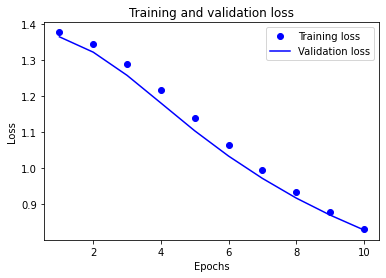

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

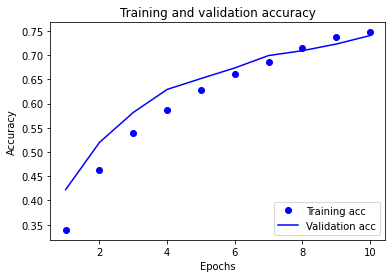

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# Export the model

In the code above, We applied the TextVectorization layer to the dataset before feeding text to the model. If We want to make the model capable of processing raw strings (for example, to simplify deploying it), We can include the TextVectorization layer inside the model. To do so, We can create a new model using the weights That are just trained.

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 3s 12ms/step - loss: 0.8647 - accuracy: 0.7240
0.7239999771118164


## Inference on new data

In [ ]:
questions = [
"how do I extract keys from a dict into a list?",  # python
"debug public static void main(string[] args) {...}",  # java
]

export_model.predict(questions)

array([[0.49262947, 0.45675555, 0.4912334 , 0.52969664],
       [0.6047643 , 0.62814325, 0.41815662, 0.38449293]], dtype=float32)

In [ ]:
# Inferencing on new data
def get_string_labels(predicted_scores_batch):
  predicted_int_labels = tf.argmax(predicted_scores_batch, axis=1)
  predicted_labels = tf.gather(raw_train_ds.class_names,
                               predicted_int_labels)
  return predicted_labels

In [ ]:
predicted_scores = export_model.predict(questions)
predicted_labels = get_string_labels(predicted_scores)
for question, label in zip(questions, predicted_labels):
  print("Question: ", question)
  print("Predicted label: ", label.numpy())

Question:  how do I extract keys from a dict into a list?
Predicted label:  b'python'
Question:  debug public static void main(string[] args) {...}
Predicted label:  b'java'
